In [607]:
import pandas
import numpy
import matplotlib
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.externals.six import StringIO  

from IPython.display import Image
import pydotplus

%matplotlib inline

In [608]:
'''read csv'''
data_frame = pandas.read_csv('data/loan_data.csv')

In [609]:
'''print first 10 rows'''
data_frame.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [610]:
'''check for null values'''
data_frame.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [611]:
'''describe numerical columns'''
data_frame.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [612]:
'''get frequery of values'''
data_frame['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

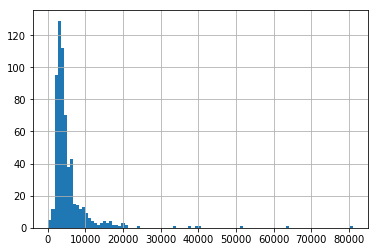

In [613]:
'''plot income distribution'''
data_frame['ApplicantIncome'].hist(bins=100)

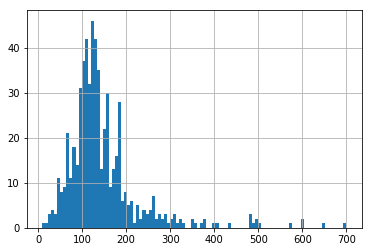

In [614]:
'''plot loan amount distribution'''
data_frame['LoanAmount'].hist(bins=100)


In [615]:
'''group by'''
data_frame.pivot_table(values='Loan_Status',index=['Credit_History'],\
                       aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

,Loan_Status
Credit_History,
0.0,0.078652
1.0,0.795789


In [616]:
data_frame.pivot_table(values='Loan_Status',index=['Education', 'Gender'],\
                       aggfunc=lambda x: x.map({'3+':3,'0':0}).mean())

Empty DataFrame
Columns: []
Index: [(Graduate, Female), (Graduate, Male), (Not Graduate, Female), (Not Graduate, Male)]

In [617]:
data_frame.pivot_table(values='Loan_Status',index=['Self_Employed', 'Property_Area'],\
                       aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

Loan_Status
Self_Employed Property_Area             
No            Rural             0.601399
              Semiurban         0.764398
              Urban             0.668675
Yes           Rural             0.653846
              Semiurban         0.781250
              Urban             0.583333

In [618]:
'''select range of values'''
data_frame.loc[(data_frame['ApplicantIncome'] < 10000) & (data_frame['ApplicantIncome'] > 5000),\
               ['Loan_Status']].apply(lambda x: x.map({'Y':1,'N':0}).mean())

Loan_Status    0.713235
dtype: float64

In [619]:
'''fill empty values'''
raw_data_frame = data_frame.copy(deep=True)
#check for empty values
def checkEmpty() :
    return data_frame.apply(lambda x: sum(x.isnull()),axis=0) 
    
checkEmpty()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [620]:
data_frame['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [621]:
data_frame['Gender'].fillna('Other', inplace=True)
data_frame['Gender'].value_counts()

Male      489
Female    112
Other      13
Name: Gender, dtype: int64

In [622]:
data_frame['Married'].fillna('No', inplace=True)

In [623]:
dependent_table = data_frame.loc[:, ['Gender', 'Dependents', 'Married']].pivot_table(columns=['Dependents'],\
                                                          index=['Gender', 'Married'], aggfunc=len)
dependent_table

Dependents          0     1     2    3+
Gender Married                         
Female No        60.0  13.0   2.0   3.0
       Yes       20.0   6.0   5.0   NaN
Male   No       109.0  10.0   6.0   3.0
       Yes      149.0  72.0  86.0  42.0
Other  No         2.0   NaN   NaN   1.0
       Yes        5.0   1.0   2.0   2.0

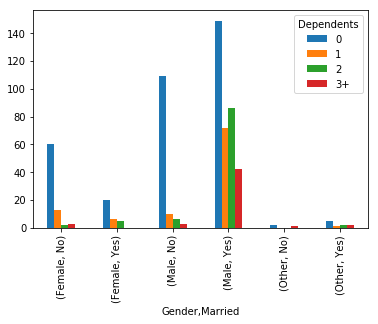

In [624]:
dependent_table.plot(kind='bar')

In [625]:
data_frame['Dependents'].fillna('0', inplace=True)
data_frame['Self_Employed'].fillna('No', inplace=True)
data_frame['Credit_History'].fillna(0.0, inplace=True)
checkEmpty()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [626]:
loan_amount_table = data_frame.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education',\
                        aggfunc=numpy.median)
loan_amount_table
#loan_amount_table.loc['No', 'Graduate']


Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


In [627]:
def getLoanAmountByOccupationAndEducation(row) :
    return loan_amount_table.loc[row['Self_Employed'], row['Education']]

loan_amount_filled = data_frame[data_frame['LoanAmount'].isnull()]\
                        .apply(getLoanAmountByOccupationAndEducation, axis=1)
loan_amount_filled

0      130.0
35     130.0
63     130.0
81     157.5
95     130.0
102    130.0
103    130.0
113    157.5
127    130.0
202    113.0
284    130.0
305    113.0
322    113.0
338    113.0
387    113.0
435    130.0
437    130.0
479    130.0
524    130.0
550    157.5
551    113.0
605    113.0
dtype: float64

In [628]:
data_frame['LoanAmount'].fillna(loan_amount_filled, inplace=True);

In [629]:
checkEmpty()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [666]:
data_frame['Loan_Amount_Term'].value_counts()

360.0    526
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [631]:
data_frame['Loan_Amount_Term'].fillna(360.0, inplace=True)

In [632]:
checkEmpty()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [633]:
#remove rows with incomplete data
# remove_null_data_frame = raw_data_frame.copy(deep=True)
# remove_null_data_frame['HasEmpty'] = remove_null_data_frame.apply(lambda x: sum(x.isnull()), axis=1)
# remove_null_data_frame
# clean_data_frame = remove_null_data_frame.loc[(remove_null_data_frame['HasEmpty'] == 0)]
# len(clean_data_frame)

In [634]:
# data_frame = clean_data_frame.loc[:, clean_data_frame.columns != 'HasEmpty']
# data_frame.head()

In [635]:
#apply predictive models

#convert all columns to numbers
column_list = data_frame.columns.values.tolist()
column_list

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status']

In [636]:
data_frame.select_dtypes(exclude=[numpy.number]).head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y


In [637]:
categorical_column_list = data_frame.select_dtypes(exclude=[numpy.number]).columns.values.tolist()
categorical_column_list

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [638]:
categorical_column_list.remove('Loan_ID')
categorical_column_list

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [639]:
label_encoder = LabelEncoder()
encoded_data_frame = data_frame.copy(deep=True)
for column in categorical_column_list: 
    encoded_data_frame[column] = label_encoder.fit_transform(encoded_data_frame[column])

encoded_data_frame.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,130.0,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


In [640]:
prepared_data_frame = encoded_data_frame.loc[:, encoded_data_frame.columns != 'Loan_ID']
prepared_data_frame.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,130.0,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


In [641]:
#separate train and test data
test_data_rows = 100
train_data = prepared_data_frame[:-test_data_rows]
#train_data
len(train_data)

514

In [642]:
test_data = prepared_data_frame[-test_data_rows:]
len(test_data)

100

In [643]:
#basic probability
train_data['Loan_Status'].mean()

0.69066147859922178

In [644]:
test_data['Loan_Status'].mean()

0.67000000000000004

In [645]:
#decision tree classifier
model = DecisionTreeClassifier()

def train_model(model, input_columns, output_column, data):
    model.fit(data[input_columns],data[output_column])
    model_prediction(model, input_columns, output_column, data)
    
def model_prediction(model, input_columns, output_column, data):
    predictions = model.predict(data[input_columns])
    #print(predictions)
    accuracy = metrics.accuracy_score(predictions,data[output_column])
    print(accuracy)


In [646]:
prepared_data_frame.columns.values

array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'], dtype=object)

In [647]:
#all columns
# input_columns = categorical_column_list[:]
# input_columns = prepared_data_frame.columns.values.tolist()
# input_columns.remove('Loan_Status')

input_columns = ['Education', 'Self_Employed', 'Credit_History', 'Property_Area']

#input_columns = ['Gender', 'Married', 'Dependents']

# input_columns = ['Education', 'Self_Employed', 'Credit_History', 'Property_Area',\
#                  'ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

#input_columns = ['ApplicantIncome', 'Credit_History', 'LoanAmount', 'CoapplicantIncome']

output_cloumn=['Loan_Status'] 
train_model(model, input_columns, output_cloumn, train_data)

0.764591439689


In [648]:
model_prediction(model, input_columns, output_cloumn, test_data)

0.78


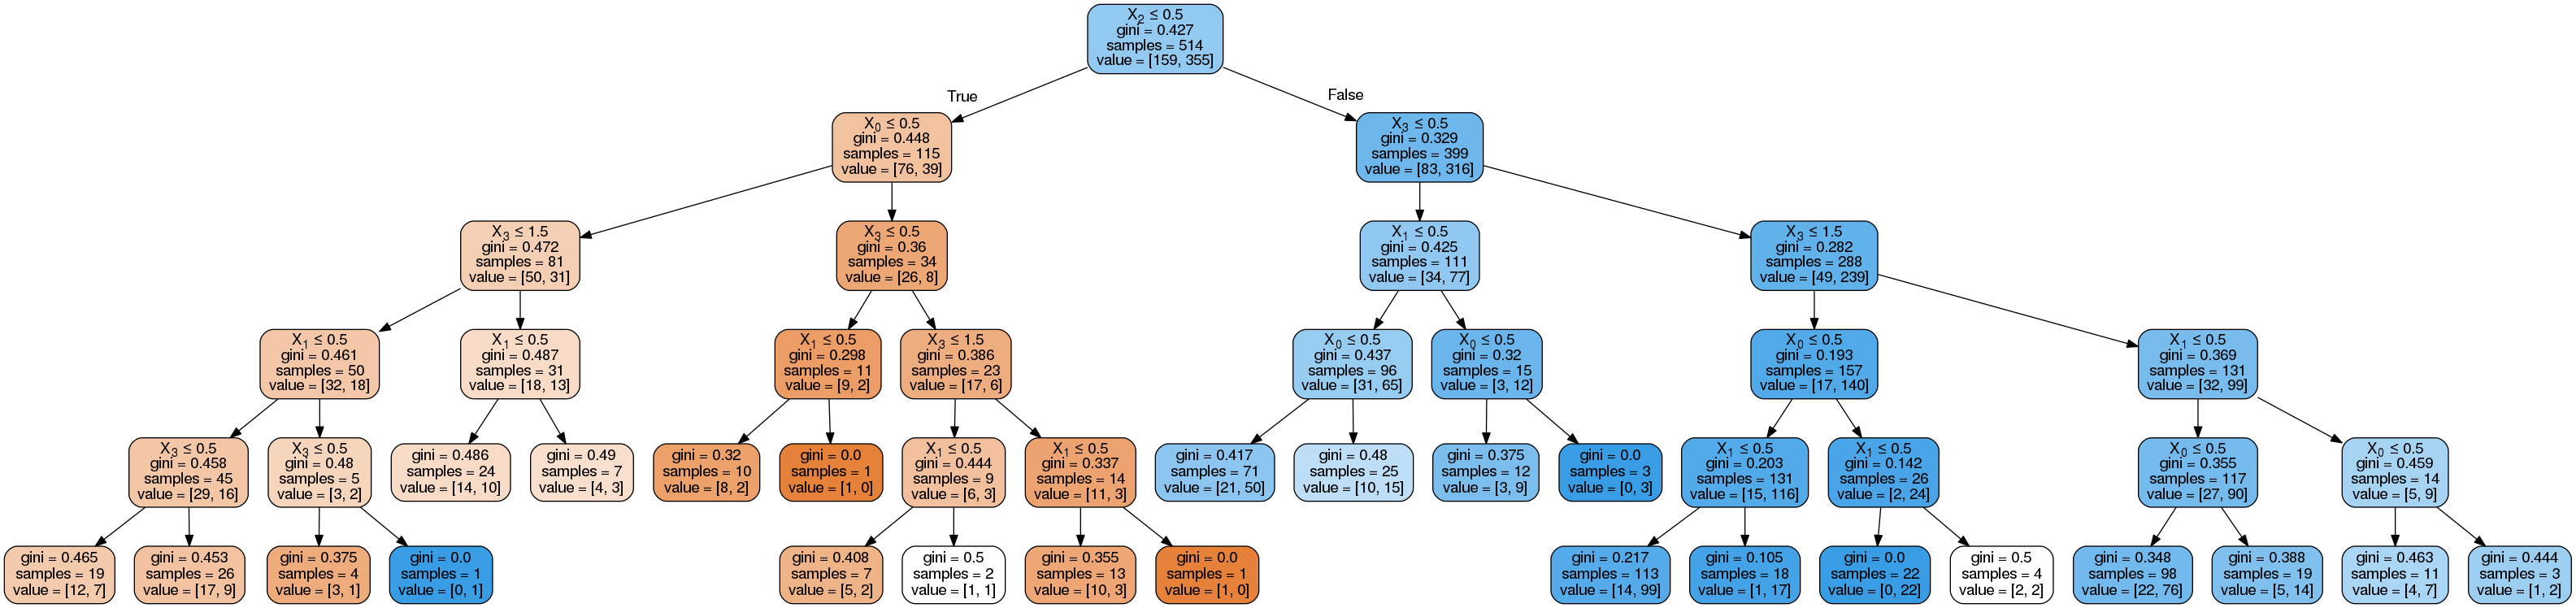

In [649]:
#visualize tree
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [650]:
#logistic regression
model = LogisticRegression()


# input_columns = categorical_column_list[:]
# input_columns = prepared_data_frame.columns.values.tolist()
# input_columns.remove('Loan_Status')

#input_columns = ['Education', 'Self_Employed', 'Credit_History', 'Property_Area']

#input_columns = ['Gender', 'Married', 'Dependents']

# input_columns = ['Education', 'Self_Employed', 'Credit_History', 'Property_Area',\
#                  'ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

input_columns = ['ApplicantIncome', 'Credit_History', 'LoanAmount', 'CoapplicantIncome']

output_cloumn=['Loan_Status']

train_model(model, input_columns, output_cloumn, train_data)

0.762645914397


In [651]:
model_prediction(model, input_columns, output_cloumn, test_data)

0.8


In [656]:
#Random Forest
# model = RandomForestClassifier()

model = RandomForestClassifier(n_estimators=100, min_samples_split=10)

# input_columns = categorical_column_list[:]
input_columns = prepared_data_frame.columns.values.tolist()
input_columns.remove('Loan_Status')

# input_columns = ['Education', 'Self_Employed', 'Credit_History', 'Property_Area']

# input_columns = ['Gender', 'Married', 'Dependents']

# input_columns = ['Education', 'Self_Employed', 'Credit_History', 'Property_Area',\
#                  'ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# input_columns = ['ApplicantIncome', 'Credit_History', 'LoanAmount', 'CoapplicantIncome']

output_cloumn=['Loan_Status']

train_model(model, input_columns, output_cloumn, train_data)

/home/shreyas/miniconda2/envs/python_practice/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.873540856031


In [658]:
model_prediction(model, input_columns, output_cloumn, test_data)

0.8


In [664]:
#Feature importance
feature_importance_table = pandas.Series(model.feature_importances_, index=input_columns)\
                                .sort_values(ascending=False)
feature_importance_table

Credit_History       0.238025
LoanAmount           0.186962
ApplicantIncome      0.186928
CoapplicantIncome    0.126599
Loan_Amount_Term     0.058123
Property_Area        0.057501
Dependents           0.045998
Gender               0.035147
Education            0.023738
Married              0.021083
Self_Employed        0.019895
dtype: float64

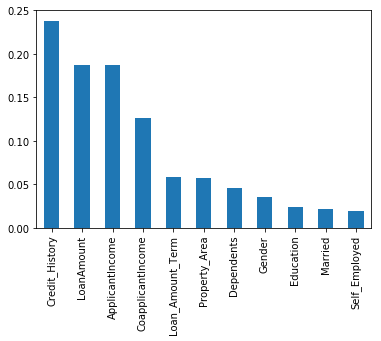

In [665]:
feature_importance_table.plot(kind='bar')